# BIBLIOTECAS

In [2]:
!pip3 install pandas numpy seaborn matplotlib

In [3]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob

# SANITY CHECK

## Objetivos:

- Entendimento inicial de cada uma das bases de dados
- Analisar propriedades das colunas das bases
- Identificar e tratar possíveis inconsistências nos dados

In [13]:
# Obter a lista de arquivos CSV no diretório
csv_files = glob.glob('../data/raw/*.csv')

df_list = [pd.read_csv(file) for file in csv_files]

In [17]:
csv_files

['../data/raw\\DemographicData_ZCTAs.csv',
 '../data/raw\\df_geocode (1).csv',
 '../data/raw\\EconomicData_ZCTAs (1).csv',
 '../data/raw\\exams_data.csv',
 '../data/raw\\transactional_data (1).csv']

In [ ]:
demographic_df = pd.read_csv(csv_files[0])
geocode_df = pd.read_csv(csv_files[1])
economic_df = pd.read_csv(csv_files[2])
exams_df = pd.read_csv(csv_files[3])
transactional_df = pd.read_csv(csv_files[4])

Dataframes criados: demographic_df, geocode_df, economic_df, exams_df, transactional_df


Dataframes criados:
- demographic_df
- geocode_df
- economic_df
- exams_df
- transactional_df

In [ ]:
def check_dataframe_quality(df: pd.DataFrame) -> dict:
    """
    Avalia a qualidade de um DataFrame em termos de valores ausentes, duplicados e tipos de dados.

    Args:
        df (pd.DataFrame): DataFrame a ser avaliado.

    Returns:
        dict: Dicionário contendo:
            - 'duplicated_rows' (int): número de linhas duplicadas;
            - 'missing_values' (pd.Series): contagem de valores ausentes por coluna.
    """
    return {
        "duplicated_rows": df.duplicated().sum(),
        "missing_values": df.isnull().sum()
    }

### Visualização do demographic_df

#### Visão geral do dataframe

In [38]:
print("Colunas do dataframe demographic:", demographic_df.columns)
print("Shape do dataframe demographic", demographic_df.shape)
print(demographic_df.info())

Colunas do dataframe demographic: Index(['Unnamed: 0', 'Id', 'GeographicAreaName', 'TotalPopulation', 'SexRatio(males per 100 females)', 'Population_Under5Years', 'Population_5to9Years', 'Population_10to14Years', 'Population_15to19Years', 'Population_20to24Years', 'Population_25to34Years', 'Population_35to44Years', 'Population_45to54Years', 'Population_55to59Years', 'Population_60to64Years', 'Population_65to74Years', 'Population_75to84Years', 'Population_85YearsAndOver', 'MedianAgeInYears'], dtype='object')
Shape do dataframe demographic (33120, 19)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33120 entries, 0 to 33119
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       33120 non-null  int64  
 1   Id                               33120 non-null  object 
 2   GeographicAreaName               33120 non-null  object 
 3   TotalPopulation     

Nota-se que a maioria das colunas da base é numérica, com características relacionadas à demografia de áreas geográficas. A maior parte das variáveis que descrevem as características populacionais são numéricas, porém existem variáveis aparentemente categóricas:

- `Id` (Identificador único da área geográfica)
- `GeographicAreaName` (Nome da área geográfica)

In [107]:
print(f"Quantidade de valores únicos na coluna 'Id': {demographic_df['Id'].nunique()}")
print(f"Quantidade de valores únicos na coluna 'GeographicAreaName': {demographic_df['GeographicAreaName'].nunique()}")

Quantidade de valores únicos na coluna 'Id': 33120
Quantidade de valores únicos na coluna 'GeographicAreaName': 33120


In [ ]:
pd.set_option('display.width', 600)
pd.set_option('display.max_columns', None)
print(demographic_df.head(5))

   Unnamed: 0              Id GeographicAreaName  TotalPopulation  SexRatio(males per 100 females)  Population_Under5Years  Population_5to9Years  Population_10to14Years  Population_15to19Years  Population_20to24Years  Population_25to34Years  Population_35to44Years  Population_45to54Years  Population_55to59Years  Population_60to64Years  Population_65to74Years  Population_75to84Years  Population_85YearsAndOver  MedianAgeInYears
0           0  8600000US35004        ZCTA5 35004            12045                             94.1                     805                  1075                     898                     477                     578                    2088                    1628                    1200                     886                     683                    1017                     534                        176              35.5
1           1  8600000US35005        ZCTA5 35005             7344                             86.1                     504                  

#### Verificando possíveis incosistências

In [94]:
negative_population = demographic_df[demographic_df["TotalPopulation"] < 0]
print(f"Quantidade de valores negativos em TotalPopulation: {negative_population.shape[0]}")

if not negative_population.empty:
    print(negative_population)

Quantidade de valores negativos em TotalPopulation: 0


#### Verificando e tratando valores ausentes

In [71]:
quality_report = check_dataframe_quality(demographic_df)

print("Valores ausentes:\n", quality_report["missing_values"])
print("\nLinhas duplicadas:", quality_report["duplicated_rows"])

Valores ausentes:
 Unnamed: 0                           0
Id                                   0
GeographicAreaName                   0
TotalPopulation                      0
SexRatio(males per 100 females)    500
Population_Under5Years               0
Population_5to9Years                 0
Population_10to14Years               0
Population_15to19Years               0
Population_20to24Years               0
Population_25to34Years               0
Population_35to44Years               0
Population_45to54Years               0
Population_55to59Years               0
Population_60to64Years               0
Population_65to74Years               0
Population_75to84Years               0
Population_85YearsAndOver            0
MedianAgeInYears                   569
dtype: int64

Linhas duplicadas: 0


In [ ]:
missing_rows = demographic_df[demographic_df.isnull().any(axis=1)]
print(missing_rows.head())

     Unnamed: 0              Id GeographicAreaName  TotalPopulation  SexRatio(males per 100 females)  Population_Under5Years  Population_5to9Years  Population_10to14Years  Population_15to19Years  Population_20to24Years  Population_25to34Years  Population_35to44Years  Population_45to54Years  Population_55to59Years  Population_60to64Years  Population_65to74Years  Population_75to84Years  Population_85YearsAndOver  MedianAgeInYears
5             5  8600000US35013        ZCTA5 35013               46                              NaN                       0                     0                       0                       0                       0                       0                      15                      31                       0                       0                       0                       0                          0              47.9
42           42  8600000US35074        ZCTA5 35074               99                             86.8                       0            

Aqui aparece algumas informações úteis, algumas dessas colunas em que SexRatio(males per 100 females) e MedianAgeInYears estão com valores ausentes, a população total da ZCTA é zero. Inicialmente cabe verificarmos essas colunas e tratar as outras que sobrarem.

1. Verificação: ZCTAs com TotalPopulation = 0 e se medianAge e sexRatio são NaN

In [75]:
pop_zero = demographic_df["TotalPopulation"] == 0

medianage_nan_when_pop_zero = demographic_df.loc[pop_zero, "MedianAgeInYears"].isnull()
sexratio_nan_when_pop_zero = demographic_df.loc[pop_zero, "SexRatio(males per 100 females)"].isnull()
both_nan_when_pop_zero = medianage_nan_when_pop_zero & sexratio_nan_when_pop_zero

print(medianage_nan_when_pop_zero.sum())
print(sexratio_nan_when_pop_zero.sum())
print(both_nan_when_pop_zero.sum())

344
344
344


Logo, como esperado, todas as linhas em que `TotalPopulation` é zero `MedianAgeInYears` e `SexRatio` estão ausentes.

2. Filtrando os casos em que MedianAgeInYears é NaN e TotalPopulation não é zero

In [89]:
filtered_df = demographic_df[~pop_zero & demographic_df["MedianAgeInYears"].isnull()]

print(filtered_df.shape)
print(filtered_df.head())

(225, 19)
     Unnamed: 0              Id GeographicAreaName  TotalPopulation  SexRatio(males per 100 females)  Population_Under5Years  Population_5to9Years  Population_10to14Years  Population_15to19Years  Population_20to24Years  Population_25to34Years  Population_35to44Years  Population_45to54Years  Population_55to59Years  Population_60to64Years  Population_65to74Years  Population_75to84Years  Population_85YearsAndOver  MedianAgeInYears
42           42  8600000US35074        ZCTA5 35074               99                             86.8                       0                     0                       0                       0                       0                      99                       0                       0                       0                       0                       0                       0                          0               NaN
97           97  8600000US35187        ZCTA5 35187                6                            100.0                       0  

In [92]:
age_columns = [col for col in demographic_df.columns if "Population_" in col and "Years" in col]
has_population_values = filtered_df[age_columns].any(axis=1).any()

has_population_values

np.True_

Aqui vemos que os 569 valores ausentes de `MedianAgeInYears`, estão separados da seguinte forma:
- 334 possuem valor 0 no total de população;
- 225 possuem valor maior que 0 em total de população, mas não foi calculada.

3. Calculando `MedianAgeInYears` nos casos em que conseguimos calcular.

In [ ]:
age_classes = {
    "Population_Under5Years": (0, 5),
    "Population_5to9Years": (5, 5),
    "Population_10to14Years": (10, 5),
    "Population_15to19Years": (15, 5),
    "Population_20to24Years": (20, 5),
    "Population_25to34Years": (25, 10),
    "Population_35to44Years": (35, 10),
    "Population_45to54Years": (45, 10),
    "Population_55to59Years": (55, 5),
    "Population_60to64Years": (60, 5),
    "Population_65to74Years": (65, 10),
    "Population_75to84Years": (75, 10),
    "Population_85YearsAndOver": (85, 15)  # estimativa para o final aberto
}

age_columns = [col for col in demographic_df.columns if "Population_" in col and "Years" in col]

def estimate_median_class(row):
    """
    Estima a mediana usando distribuição em classes para faixas etárias.
    
    Args:
        row (pd.Series): Linha com dados de população por faixa etária.
    
    Returns:
        float: Idade mediana estimada ou None.
    """
    frequencies = [(col, row[col]) for col in age_columns if pd.notnull(row[col]) and row[col] > 0]
    total_pop = sum(freq for _, freq in frequencies)

    if total_pop == 0:
        return None

    cumulative = 0
    for col, freq in frequencies:
        cumulative += freq
        if cumulative >= total_pop / 2:
            L, w = age_classes[col]
            prev_cum = cumulative - freq
            median = L + (((total_pop / 2) - prev_cum) / freq) * w
            return median

    return None

def should_apply_median(row):
    pop_sum = row[age_columns].sum()
    return pop_sum == row["TotalPopulation"]

Nos casos em que existem populações e os dados das colunas de faixas etárias estão preenchidas, conseguimos calcular `MedianAgeInYear`

In [ ]:
filtered_df.loc[filtered_df.apply(should_apply_median, axis=1), "MedianAgeInYears"] = filtered_df[filtered_df.apply(should_apply_median, axis=1)].apply(estimate_median_class, axis=1)

filtered_df.head()

,Unnamed: 0,Id,GeographicAreaName,TotalPopulation,SexRatio(males per 100 females),Population_Under5Years,Population_5to9Years,Population_10to14Years,Population_15to19Years,Population_20to24Years,Population_25to34Years,Population_35to44Years,Population_45to54Years,Population_55to59Years,Population_60to64Years,Population_65to74Years,Population_75to84Years,Population_85YearsAndOver,MedianAgeInYears,age_columns_sum,has_age_values,age_sum_matches_population
42,42,8600000US35074,ZCTA5 35074,99,86.8,0,0,0,0,0,99,0,0,0,0,0,0,0,30.000000,99,True,True
97,97,8600000US35187,ZCTA5 35187,6,100.0,0,0,0,0,0,0,0,0,0,0,6,0,0,70.000000,6,True,True
178,178,8600000US35559,ZCTA5 35559,12,100.0,0,0,0,0,0,0,6,6,0,0,0,0,0,45.000000,12,True,True
207,207,8600000US35615,ZCTA5 35615,60,252.9,0,0,0,0,0,0,43,0,17,0,0,0,0,41.976744,60,True,True
403,403,8600000US36267,ZCTA5 36267,7,NaN,0,0,0,0,0,0,0,0,7,0,0,0,0,57.500000,7,True,True


4. Filtrando os casos em que `SexRatio(males per 100 females)` é NaN e TotalPopulation não é zero

In [95]:
filtered_sexratio_nan = demographic_df[(demographic_df["TotalPopulation"] != 0) & (demographic_df["SexRatio(males per 100 females)"].isnull())]

print(filtered_sexratio_nan)

       Unnamed: 0              Id GeographicAreaName  TotalPopulation  SexRatio(males per 100 females)  Population_Under5Years  Population_5to9Years  Population_10to14Years  Population_15to19Years  Population_20to24Years  Population_25to34Years  Population_35to44Years  Population_45to54Years  Population_55to59Years  Population_60to64Years  Population_65to74Years  Population_75to84Years  Population_85YearsAndOver  MedianAgeInYears
5               5  8600000US35013        ZCTA5 35013               46                              NaN                       0                     0                       0                       0                       0                       0                      15                      31                       0                       0                       0                       0                          0              47.9
403           403  8600000US36267        ZCTA5 36267                7                              NaN                       0      

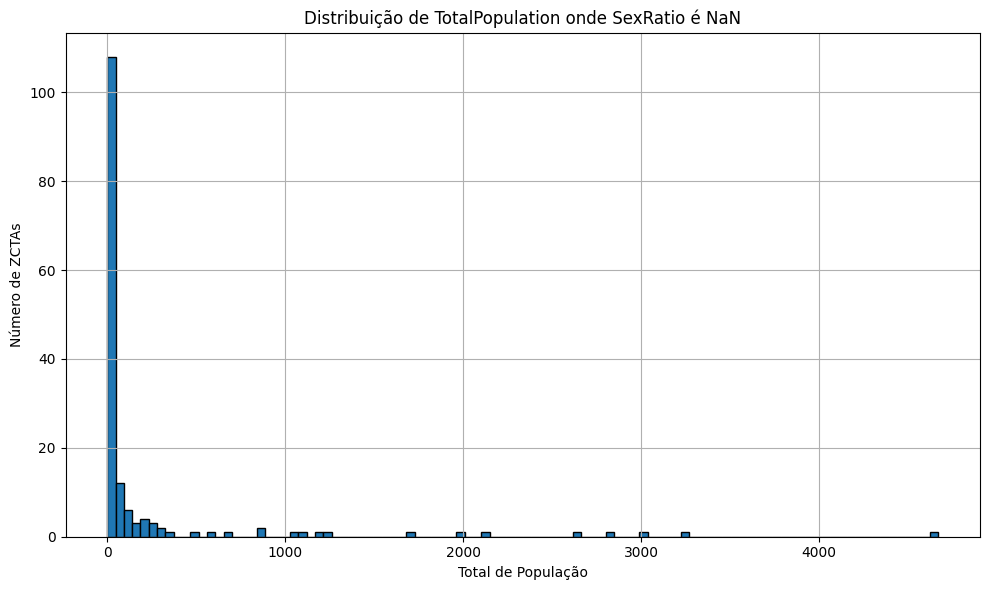

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(filtered_sexratio_nan["TotalPopulation"], bins=100, edgecolor='black')
plt.title("Distribuição de TotalPopulation onde SexRatio é NaN")
plt.xlabel("Total de População")
plt.ylabel("Número de ZCTAs")
plt.grid(True)
plt.tight_layout()
plt.show()

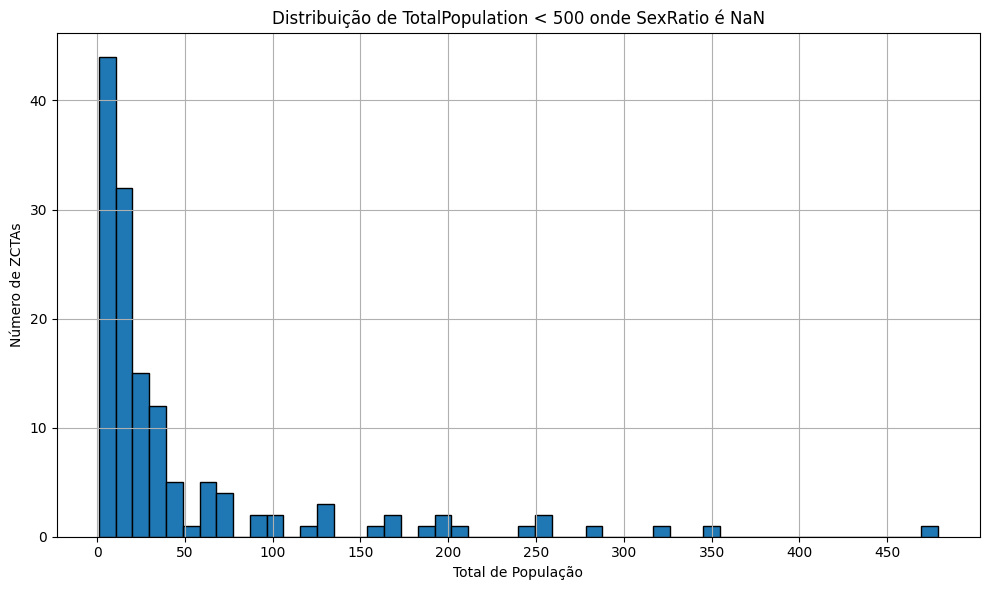

In [106]:
filtered_population = filtered_sexratio_nan[filtered_sexratio_nan["TotalPopulation"] < 500]

plt.figure(figsize=(10, 6))
plt.hist(filtered_population["TotalPopulation"], bins=50, edgecolor='black')
plt.title("Distribuição de TotalPopulation < 500 onde SexRatio é NaN")
plt.xlabel("Total de População")
plt.ylabel("Número de ZCTAs")
plt.grid(True)
plt.xticks(np.arange(0, 500, 50))  # Adiciona mais marcações no eixo x
plt.tight_layout()
plt.show()

Com base nos dois histogramas, observamos uma concentração significativa de casos em que o SexRatio é NaN em regiões com população total bastante reduzida. Essa ausência de razão entre gêneros, poderia ser causada pela presença de indivíduos de um único gênero nesses ZCTAs, inviabilizando o cálculo da razão.

#### Verificando e tratando outliers

### Visualização do geocode_df

In [39]:
print("Colunas do dataframe geocode:", geocode_df.columns)
print("Shape do dataframe geocode", geocode_df.shape)
print(geocode_df.info())

Colunas do dataframe geocode: Index(['Unnamed: 0', 'Lab Id', 'Address', 'Location', 'Zipcode'], dtype='object')
Shape do dataframe geocode (119, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119 entries, 0 to 118
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  119 non-null    int64  
 1   Lab Id      119 non-null    object 
 2   Address     119 non-null    object 
 3   Location    119 non-null    object 
 4   Zipcode     118 non-null    float64
dtypes: float64(1), int64(1), object(3)
memory usage: 4.8+ KB
None


In [41]:
print(geocode_df.head(5))

   Unnamed: 0 Lab Id                                            Address                 Location  Zipcode
0           0   L152      3800 PLEASANT HILL RD STE 1, DULUTH, GA 30096    34.000319,-84.1629724  30096.0
1           1   L520                    1614 N JAMES ST, ROME, NY 13440   43.2311327,-75.4445363  13440.0
2           2   L141     12911 120TH AVE NE STE D60, KIRKLAND, WA 98034  47.7162786,-122.1838152  98034.0
3           3   L524  5667 PEACHTREE DUNWOODY RD 250, ATLANTA, GA 30342   33.9093875,-84.3529096  30342.0
4           4   L545                 1204 IL HWY 164, OQUAWKA, IL 61469   40.9309925,-90.9437598  61469.0


### Visualização do economic_df

In [42]:
print("Colunas do dataframe economic:", economic_df.columns)
print("Shape do dataframe economic", economic_df.shape)
print(economic_df.info())

Colunas do dataframe economic: Index(['Unnamed: 0', 'id', 'Geographic Area Name', 'TotalHouseholds_LessThan$10.000', 'TotalHouseholds_$10.000to$14.999', 'TotalHouseholds_$15.000to$24.999', 'TotalHouseholds_$25.000to$34.999', 'TotalHouseholds_$35.000to$49.999', 'TotalHouseholds_$50.000to$74.999', 'TotalHouseholds_$75.000to$99.999', 'TotalHouseholds_$100.000to$149.999', 'TotalHouseholds_$150.000to$199.999', 'TotalHouseholds_$200.000OrMore'], dtype='object')
Shape do dataframe economic (629280, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629280 entries, 0 to 629279
Data columns (total 13 columns):
 #   Column                              Non-Null Count   Dtype 
---  ------                              --------------   ----- 
 0   Unnamed: 0                          629280 non-null  int64 
 1   id                                  629280 non-null  object
 2   Geographic Area Name                629280 non-null  object
 3   TotalHouseholds_LessThan$10.000     629280 non-null  int64

In [43]:
pd.set_option('display.width', 600)
pd.set_option('display.max_columns', None)
print(economic_df.head(5))

   Unnamed: 0              id Geographic Area Name  TotalHouseholds_LessThan$10.000  TotalHouseholds_$10.000to$14.999  TotalHouseholds_$15.000to$24.999  TotalHouseholds_$25.000to$34.999  TotalHouseholds_$35.000to$49.999  TotalHouseholds_$50.000to$74.999  TotalHouseholds_$75.000to$99.999  TotalHouseholds_$100.000to$149.999  TotalHouseholds_$150.000to$199.999  TotalHouseholds_$200.000OrMore
0           0  8600000US35004          ZCTA5 35004                              198                                71                               298                               513                               647                              1117                               529                                 945                                 245                              61
1           1  8600000US35005          ZCTA5 35005                              188                               184                               318                               293                               

### Visualização do exams_df

In [44]:
print("Colunas do dataframe exams:", exams_df.columns)
print("Shape do dataframe exams", exams_df.shape)
print(exams_df.info())

Colunas do dataframe exams: Index(['CodItem', 'Desc Item', 'Category', 'Family', 'Speciality', 'Testing Cost'], dtype='object')
Shape do dataframe exams (2002, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2002 entries, 0 to 2001
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CodItem       2002 non-null   int64  
 1   Desc Item     2002 non-null   object 
 2   Category      2002 non-null   object 
 3   Family        2002 non-null   object 
 4   Speciality    2002 non-null   object 
 5   Testing Cost  2002 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 94.0+ KB
None


In [52]:
print(exams_df.isnull().sum())

CodItem         0
Desc Item       0
Category        0
Family          0
Speciality      0
Testing Cost    0
dtype: int64


In [ ]:
print(exams_df.head(5))

    CodItem                                          Desc Item Category   Family     Speciality  Testing Cost
0  70003237  MAGNESIO, SORO (EXEMPLO DE EXPRESSAO DE RESULT...       CA  CORELAB   BIOCHEMISTRY          1.78
1  70000638                    HEMOGRAMA, AUTOMATIZADO, SANGUE       CA   HEMATO    BLOOD COUNT          2.46
2  70001597                                    FERRITINA, SORO       CA  CORELAB  IMMUNOHORMONE          2.11
3  70000103  FERRO, DOSAGEM, SORO (EXEMPLO DE EXPRESSAO DE ...       CA  CORELAB   BIOCHEMISTRY          0.80
4  70000224  CALCIO, DOSAGEM, SORO (EXEMPLO DE EXPRESSAO DE...       CA  CORELAB   BIOCHEMISTRY          1.02


### Visualização do transactional_df

In [ ]:
print("Colunas do dataframe transactional:", transactional_df.columns)
print("Shape do dataframe transactional", transactional_df.shape)
print(transactional_df.info())

Colunas do dataframe transactional: Index(['Patient Id;Gender;Date of birth;Date of service;Service Id;Lab Id;CodItem;Testing Cost'], dtype='object')
Shape do dataframe transactional (2355241, 1)
<class 'pandas.core.frame.DataFrame'>
Index: 2355241 entries, 10210830256-BIO003;F;01/08/1976 00:00:00;2019-01-07;571904533475-38;L133;70003237;9 to 7664157546-1;M;06/03/1971 00:00:00;2021-02-12;7664157546-1-1;L697;70000392;8
Data columns (total 1 columns):
 #   Column                                                                                  Dtype
---  ------                                                                                  -----
 0   Patient Id;Gender;Date of birth;Date of service;Service Id;Lab Id;CodItem;Testing Cost  int64
dtypes: int64(1)
memory usage: 35.9+ MB
None


Aqui observamos que o dataframe foi lido de maneira incorreta, então precisou-se ajustar para fazer a leitura correta

In [ ]:
transactional_df = pd.read_csv(csv_files[4], sep=';', index_col=False)

print("Colunas do dataframe transactional ajustado:", transactional_df.columns)
print("Shape do dataframe transactional ajustado", transactional_df.shape)
print(transactional_df.info())

Colunas do dataframe transactional ajustado: Index(['Patient Id', 'Gender', 'Date of birth', 'Date of service', 'Service Id', 'Lab Id', 'CodItem', 'Testing Cost'], dtype='object')
Shape do dataframe transactional ajustado (2355241, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2355241 entries, 0 to 2355240
Data columns (total 8 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   Patient Id       object
 1   Gender           object
 2   Date of birth    object
 3   Date of service  object
 4   Service Id       object
 5   Lab Id           object
 6   CodItem          int64 
 7   Testing Cost     object
dtypes: int64(1), object(7)
memory usage: 143.8+ MB
None


In [60]:
print(transactional_df.isnull().sum())

Patient Id         0
Gender             0
Date of birth      1
Date of service    0
Service Id         0
Lab Id             0
CodItem            0
Testing Cost       0
dtype: int64


In [61]:
print(transactional_df[transactional_df.isnull().any(axis=1)])

           Patient Id Gender Date of birth Date of service      Service Id Lab Id   CodItem  Testing Cost
1253947  7659985004-1      F           NaN      2020-02-22  7659985004-2-1   L152  70000107          48.0


Preciso entender como tratar essa linha

In [ ]:
# Remover espaços em branco e normalizar a coluna 'Testing Cost'
transactional_df['Testing Cost'] = transactional_df['Testing Cost'].str.replace(',', '.').astype(float)

# Verificar duplicatas considerando todas as colunas
duplicated_rows = transactional_df[transactional_df.duplicated()]
print(duplicated_rows.head(2))

             Patient Id Gender        Date of birth Date of service        Service Id Lab Id   CodItem  Testing Cost
110  10240091057-BIO010      F  12/07/1976 00:00:00      2019-01-09  430000507035-168   L536  70005005          59.0
325  10240100137-BIO010      F  19/01/1987 00:00:00      2019-02-03  431300349554-172   L539  70000180          12.0


In [56]:
transactional_df[transactional_df.duplicated()]

,Patient Id,Gender,Date of birth,Date of service,Service Id,Lab Id,CodItem,Testing Cost
110,10240091057-BIO010,F,12/07/1976 00:00:00,2019-01-09,430000507035-168,L536,70005005,"59,0"
325,10240100137-BIO010,F,19/01/1987 00:00:00,2019-02-03,431300349554-172,L539,70000180,"12,0"
326,10240100137-BIO010,F,19/01/1987 00:00:00,2019-02-03,431300349554-172,L539,70000180,"12,0"
731,10210824046-BIO003,F,13/04/1957 00:00:00,2019-01-15,576401751254-89,L166,70000180,"12,0"
732,10210824046-BIO003,F,13/04/1957 00:00:00,2019-01-15,576401751254-89,L166,70000180,"12,0"
...,...,...,...,...,...,...,...,...
2354236,6004062388-1,F,13/09/1986 00:00:00,2021-01-13,6004062388-3-1,L139,70000819,"30,0"
2354238,6004062388-1,F,13/09/1986 00:00:00,2021-01-13,6004062388-3-1,L139,70006315,"26,0"
2354554,7664121334-1,F,07/11/1947 00:00:00,2021-02-09,7664121334-2-1,L155,70002747,"81,0"
2354885,7658735373-1,M,08/11/1978 00:00:00,2021-01-29,7658735373-15-1,L158,70000180,"12,0"


In [50]:
pd.set_option('display.width', 600)
pd.set_option('display.max_columns', None)
print(transactional_df.head(5))

           Patient Id Gender        Date of birth Date of service       Service Id Lab Id   CodItem Testing Cost
0  10210830256-BIO003      F  01/08/1976 00:00:00      2019-01-07  571904533475-38   L133  70003237          9,0
1  10210830256-BIO003      F  01/08/1976 00:00:00      2019-01-07  571904533475-38   L133  70000638         13,0
2  10210830256-BIO003      F  01/08/1976 00:00:00      2019-01-07  571904533475-38   L133  70001597         49,0
3  10210830256-BIO003      F  01/08/1976 00:00:00      2019-01-07  571904533475-38   L133  70000103         11,0
4  10210830256-BIO003      F  01/08/1976 00:00:00      2019-01-07  571904533475-38   L133  70000224         10,0


# EDA